In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(tidyverse)
library(RColorBrewer)
library(cowplot)
library(repr)
library(circlize)
library(ComplexHeatmap)
library(grid)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
✔ readr     2.1.5     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() mask

In [9]:
bm_lognorm <- readRDS("RDS/bm_julia_lognorm_cellType_v1.rds")
bmAtlas <- readRDS("RDS/GSE253355_Normal_Bone_Marrow_Atlas_Seurat_SB_v2.rds")
bm_new <- readRDS("/diskmnt/Projects/SenNet_analysis/Main.analysis/bm/scRNA/merged/05202024_WC/merge_05202024_WC.rds")

In [10]:
colnames(bm_lognorm[[]])
colnames(bmAtlas[[]])
colnames(bm_new[[]])

[1] "orig.ident"         "nCount_RNA"         "nFeature_RNA"      
 [4] "rho"                "percent.mt"         "percent.rb"        
 [7] "doublet_score"      "predicted_doublet"  "S.Score"           
[10] "G2M.Score"          "Phase"              "nCount_SCT"        
[13] "nFeature_SCT"       "SCT_snn_res.0.5"    "seurat_clusters"   
[16] "sample_id"          "old.ident"          "CC.Difference"     
[19] "UPN"                "age"                "banking"           
[22] "throughput"         "tissue_processing"  "annot"             
[25] "annot_f"            "SCT_snn_res.0.8"    "SCT_clusters"      
[28] "WC_annot"           "RNA_snn_res.0.8"    "LogNorm_clusters"  
[31] "WC_annot_2"         "predicted.id.score" "predicted.id"      
[34] "pred_cell_type"

[1] "orig.ident"          "nCount_RNA"          "nFeature_RNA"       
 [4] "percent.mt"          "cluster_anno_l2"     "cluster_anno_coarse"
 [7] "cluster_anno_l1"     "Sex"                 "Age"                
[10] "Ethnicity"

[1] "orig.ident"             "nCount_RNA"             "nFeature_RNA"          
 [4] "rho"                    "percent.mt"             "percent.rb"            
 [7] "doublet_score"          "predicted_doublet"      "S.Score"               
[10] "G2M.Score"              "Phase"                  "nCount_SCT"            
[13] "nFeature_SCT"           "SCT_snn_res.0.5"        "seurat_clusters"       
[16] "old.ident"              "CC.Difference"          "Sample_ID"             
[19] "SCT_snn_res.0.6"        "Site_of_origin"         "SCT_snn_res.0.8"       
[22] "cluster_anno_WC"        "cluster_anno_coarse_WC"

In [11]:
unique(bm_lognorm$WC_annot_2)

[1] Erythroblast-1        RBC                   Osteoblast           
 [4] DC?                   Plasma                Endothelial          
 [7] Macrophage            Erythroblast-2        MSC                  
[10] Myeloid-cell-2        vSMC                  B-cell               
[13] pDC                   T-cell-like           Myocyte-1            
[16] Fibroblast-like-2     T-Cell                Myocyte-2            
[19] Myeloid-cell-1        Unknown-1             Unknown-2            
[22] Pericyte              Adipocyte             plasma/pDC/osteocyte 
[25] Fibroblast-like-1     Chondrocyte           Granulocyte          
[28] Lymphatic-endothelial T/NK-cell             MSC/Osteo-progenitor 
30 Levels: Fibroblast-like-1 RBC Chondrocyte T-Cell ... MSC/Osteo-progenitor

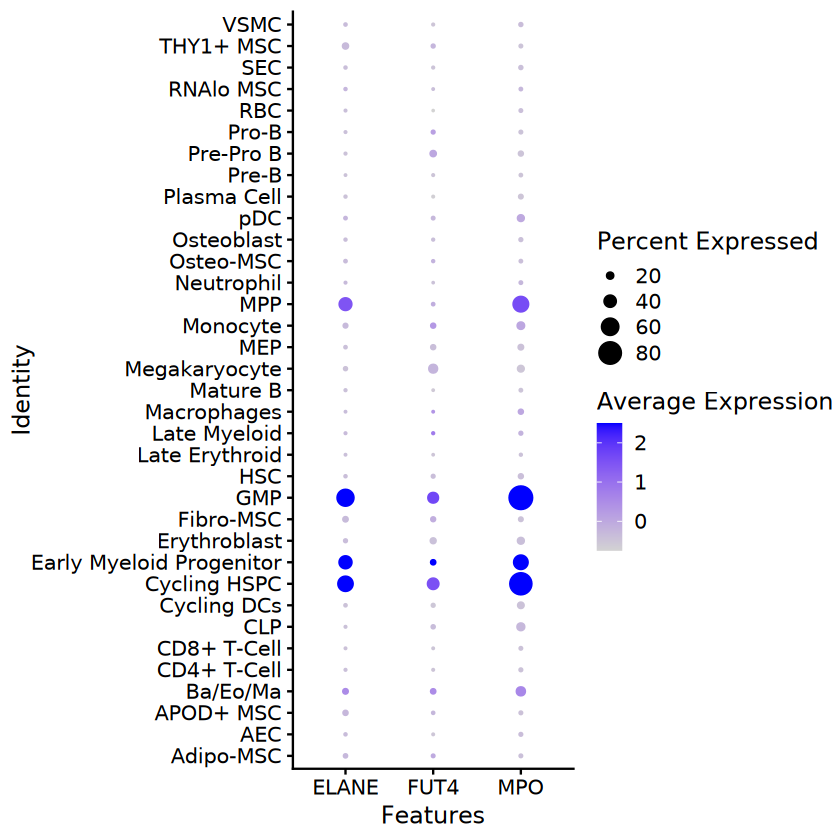

In [30]:
DotPlot(bmAtlas, features = c("ELANE", "FUT4", "MPO"))

### Pre-process metadata columns

In [19]:
bm_lognorm$Age <- bm_lognorm$age
bm_lognorm$Sample_ID <- bm_lognorm$UPN
bmAtlas$Sample_ID <- bmAtlas$orig.ident
bm_lognorm$orig_anno <- bm_lognorm$WC_annot_2
bmAtlas$orig_anno <- bmAtlas$cluster_anno_l2
bm_new$orig_anno <- bm_new$cluster_anno_WC
bmAtlas$Site_of_origin <- "Hip"
bm_lognorm$Site_of_origin <- "Hip"
bm_lognorm$data_source <- "Old sn merge"
bmAtlas$data_source <- "Kai Tan reference"
bm_new$data_source <- "New sc merge"
bm_lognorm$data_type_rna <- "snRNA"
bmAtlas$data_type_rna <- "scRNA"
bm_new$data_type_rna <- "scRNA"

# Merge

In [20]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes

DefaultAssay(bm_lognorm) <- "RNA"
bm_lognorm <- DietSeurat(bm_lognorm, assay = "RNA", layer = "counts")
DefaultAssay(bmAtlas) <- "RNA"
bmAtlas <- DietSeurat(bmAtlas, assay = "RNA", layer = "counts")
DefaultAssay(bm_new) <- "RNA"
bm_new <- DietSeurat(bm_new, assay = "RNA", layer = "counts")

bm_merge <- merge(x = bmAtlas, y = list(bm_lognorm, bm_new), merge.data = FALSE)
bm_merge <- CellCycleScoring(bm_merge, s.features = s.genes, g2m.features = g2m.genes, assay='RNA', set.ident = TRUE)
bm_merge$CC.Difference <- bm_merge$S.Score - bm_merge$G2M.Score

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”


### Try no integration

In [21]:
bm_merge <- bm_merge %>% SCTransform(vars.to.regress = c("percent.mt", "nCount_RNA", "nFeature_RNA", "CC.Difference")) %>%
    RunPCA(npcs = 50) %>% RunUMAP(reduction = "pca", dims = 1:30, seed.use = 42) %>% FindNeighbors(reduction = "pca", dims = 1:30) %>%
    FindClusters()

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 33113 by 140834

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Found 124 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 33113 genes

Computing corrected count matrix for 33113 genes

Calculating gene attributes

Wall clock passed: Time difference of 16.23775 mins

Determine variable features

Regressing out percent.mt, nCount_RNA, nFeature_RNA, CC.Difference

Centering data matrix

Place corrected count matrix in counts slot

Set default assay to SCT

PC_ 1 
Positive:  S100A8, S100A9, S100A12, LTF, LCN2, CAMP, LYZ, PADI4, MMP9, MNDA 
	   CRISP3, MMP8, RETN, CYBB, ABCA13, PGLYRP1, CXCL8, PLBD1, FCN1, NAMPT 
	   S100P

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 140834
Number of edges: 4493449

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9542
Number of communities: 47
Elapsed time: 33 seconds


In [29]:
pdf("bm_merge_inhouse_TanRef_v1_NoIntegration_PC30_UMAPs.pdf", width = 8, height = 6)
print(DimPlot(bm_merge, group.by = "seurat_clusters", label = TRUE))
print(DimPlot(bm_merge, group.by = "Sample_ID", label = TRUE))
print(DimPlot(bm_merge, group.by = "data_source", label = TRUE))
print(DimPlot(bm_merge, group.by = "data_type_rna", label = TRUE))
print(DimPlot(bm_merge, group.by = "Site_of_origin", label = TRUE))
dev.off()

pdf("bm_merge_inhouse_TanRef_v1_NoIntegration_PC30_UMAP_origIdent.pdf", width = 20, height = 8)
print(DimPlot(bm_merge, group.by = "orig_anno", label = TRUE))
dev.off()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



png 
  2

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



png 
  2

In [24]:
saveRDS(bm_merge, "RDS/bm_merge_inhouse_TanRef_v1_NoIntegration.rds")

## Try integration

In [31]:
DefaultAssay(bm_merge) <- "RNA"
bm_merge <- DietSeurat(bm_merge, assay = "RNA", layer = "counts")
bm_merge[["RNA"]] <- split(bm_merge[["RNA"]], f = bm_merge$data_source)
bm_merge <- bm_merge %>% SCTransform(vars.to.regress = c("percent.mt", "nCount_RNA", "nFeature_RNA", "CC.Difference")) %>%
    RunPCA(npcs = 50) %>% RunUMAP(reduction = "pca", dims = 1:30, seed.use = 42) %>% FindNeighbors(reduction = "pca", dims = 1:30) %>%
    FindClusters()
saveRDS(bm_merge, "RDS/bm_merge_inhouse_TanRef_v1_preIntegration_normalized.rds")

# Plot pre-integration UMAPs
pdf("bm_merge_inhouse_TanRef_v1_PreIntegration_PC30_UMAPs.pdf", width = 8, height = 6)
print(DimPlot(bm_merge, group.by = "seurat_clusters", label = TRUE))
print(DimPlot(bm_merge, group.by = "Sample_ID", label = TRUE))
print(DimPlot(bm_merge, group.by = "data_source", label = TRUE))
print(DimPlot(bm_merge, group.by = "data_type_rna", label = TRUE))
print(DimPlot(bm_merge, group.by = "Site_of_origin", label = TRUE))
dev.off()
pdf("bm_merge_inhouse_TanRef_v1_PreIntegration_PC30_UMAP_origIdent.pdf", width = 20, height = 8)
print(DimPlot(bm_merge, group.by = "orig_anno", label = TRUE))
dev.off()

# RPCA integration
bm_merge_RPCAInt <- IntegrateLayers(bm_merge, method = RPCAIntegration, 
                                    orig.reduction = "pca", new.reduction = "integrated.rpca", normalization.method = "SCT")
bm_merge_RPCAInt <- RunUMAP(bm_merge_RPCAInt, reduction = "integrated.rpca", dims = 1:30, seed.use = 42) %>% 
    FindNeighbors(reduction = "integrated.rpca", dims = 1:30) %>% FindClusters()
saveRDS(bm_merge_RPCAInt, "RDS/bm_merge_inhouse_TanRef_v1_RPCAIntegration.rds")
# Plot RPCA integration UMAPs
pdf("bm_merge_inhouse_TanRef_v1_RPCAIntegration_PC30_UMAPs.pdf", width = 8, height = 6)
print(DimPlot(bm_merge_RPCAInt, group.by = "seurat_clusters", label = TRUE))
print(DimPlot(bm_merge_RPCAInt, group.by = "Sample_ID", label = TRUE))
print(DimPlot(bm_merge_RPCAInt, group.by = "data_source", label = TRUE))
print(DimPlot(bm_merge_RPCAInt, group.by = "data_type_rna", label = TRUE))
print(DimPlot(bm_merge_RPCAInt, group.by = "Site_of_origin", label = TRUE))
dev.off()
pdf("bm_merge_inhouse_TanRef_v1_RPCAIntegration_PC30_UMAP_origIdent.pdf", width = 20, height = 8)
print(DimPlot(bm_merge_RPCAInt, group.by = "orig_anno", label = TRUE))
dev.off()

# Harmony integration
bm_merge_HarInt <- IntegrateLayers(bm_merge, method = HarmonyIntegration, 
                                    orig.reduction = "pca", new.reduction = "integrated.harmony", normalization.method = "SCT")
bm_merge_HarInt <- RunUMAP(bm_merge_HarInt, reduction = "integrated.harmony", dims = 1:30, seed.use = 42) %>% 
    FindNeighbors(reduction = "integrated.harmony", dims = 1:30) %>% FindClusters()
saveRDS(bm_merge_HarInt, "RDS/bm_merge_inhouse_TanRef_v1_HarmonyIntegration.rds")
# Plot Harmony integration UMAPs
pdf("bm_merge_inhouse_TanRef_v1_HarmonyIntegration_PC30_UMAPs.pdf", width = 8, height = 6)
print(DimPlot(bm_merge_HarInt, group.by = "seurat_clusters", label = TRUE))
print(DimPlot(bm_merge_HarInt, group.by = "Sample_ID", label = TRUE))
print(DimPlot(bm_merge_HarInt, group.by = "data_source", label = TRUE))
print(DimPlot(bm_merge_HarInt, group.by = "data_type_rna", label = TRUE))
print(DimPlot(bm_merge_HarInt, group.by = "Site_of_origin", label = TRUE))
dev.off()
pdf("bm_merge_inhouse_TanRef_v1_HarmonyIntegration_PC30_UMAP_origIdent.pdf", width = 20, height = 8)
print(DimPlot(bm_merge_HarInt, group.by = "orig_anno", label = TRUE))
dev.off()


Warning message:
“Input is a v3 assay and `split()` only works for v5 assays; converting
• to a v5 assay”
Warning message:
“Assay RNA changing from Assay to Assay5”
Running SCTransform on assay: RNA

Running SCTransform on layer: counts.Kai_Tan_reference

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 28659 by 82742

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Found 155 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 28659 genes

Computing corrected count matrix for 28659 genes

Calculating gene attributes

Wall clock passed: Time difference of 7.333052 mins

Determine variable features

Regressing out percent.mt, nCount_RNA, nFeature_RNA, CC.Difference

Centering data matrix

Getting residuals for block 1(of 17) for Kai_Tan_reference dataset

Getting re

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 140834
Number of edges: 4374325

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9561
Number of communities: 55
Elapsed time: 32 seconds


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



png 
  2

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



png 
  2

Computing within dataset neighborhoods

Finding all pairwise anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 2040 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 3358 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 2448 anchors

Merging dataset 2 into 3

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 3 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

13:16:29 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

13:16:29 Read 140834 rows and found 30 numeric columns

13:16:29 Using Annoy for neighbor search,

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 140834
Number of edges: 4350386

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9542
Number of communities: 58
Elapsed time: 43 seconds


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



png 
  2

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



png 
  2

Warning message:
“HarmonyMatrix is deprecated and will be removed in the future from the API in the future”
Warning message:
“Warning: The parameters do_pca and npcs are deprecated. They will be ignored for this function call and please remove parameters do_pca and npcs and pass to harmony cell_embeddings directly.
This warning is displayed once per session.”
Warning message:
“Warning: The parameter tau is deprecated. It will be ignored for this function call and please remove parameter tau in future function calls. Advanced users can set value of parameter tau by using parameter .options and function harmony_options().
This warning is displayed once per session.”
Warning message:
“Warning: The parameter block.size is deprecated. It will be ignored for this function call and please remove parameter block.size in future function calls. Advanced users can set value of parameter block.size by using parameter .options and function harmony_options().
This warning is displayed once per sessi

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 140834
Number of edges: 4405659

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9626
Number of communities: 63
Elapsed time: 31 seconds


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



png 
  2

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



png 
  2

In [32]:
# CCA integration
bm_merge_CCAInt <- IntegrateLayers(bm_merge, method = CCAIntegration, 
                                    orig.reduction = "pca", new.reduction = "integrated.cca", normalization.method = "SCT")
bm_merge_CCAInt <- RunUMAP(bm_merge_CCAInt, reduction = "integrated.cca", dims = 1:30, seed.use = 42) %>% 
    FindNeighbors(reduction = "integrated.cca", dims = 1:30) %>% FindClusters()
saveRDS(bm_merge_CCAInt, "RDS/bm_merge_inhouse_TanRef_v1_CCAIntegration.rds")
# Plot Harmony integration UMAPs
pdf("bm_merge_inhouse_TanRef_v1_CCAIntegration_PC30_UMAPs.pdf", width = 8, height = 6)
print(DimPlot(bm_merge_CCAInt, group.by = "seurat_clusters", label = TRUE))
print(DimPlot(bm_merge_CCAInt, group.by = "Sample_ID", label = TRUE))
print(DimPlot(bm_merge_CCAInt, group.by = "data_source", label = TRUE))
print(DimPlot(bm_merge_CCAInt, group.by = "data_type_rna", label = TRUE))
print(DimPlot(bm_merge_CCAInt, group.by = "Site_of_origin", label = TRUE))
dev.off()
pdf("bm_merge_inhouse_TanRef_v1_CCAIntegration_PC30_UMAP_origIdent.pdf", width = 20, height = 8)
print(DimPlot(bm_merge_CCAInt, group.by = "orig_anno", label = TRUE))
dev.off()

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 19809 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 29608 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 15629 anchors

Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 3 into 1 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

14:12:24 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

14:12:24 Read 140834 rows and found 30 numeric columns

14:12:24 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGene

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 140834
Number of edges: 4400240

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9502
Number of communities: 54
Elapsed time: 31 seconds


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



png 
  2

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



png 
  2

# Merge (only scRNA data)

In [33]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes

DefaultAssay(bmAtlas) <- "RNA"
bmAtlas <- DietSeurat(bmAtlas, assay = "RNA", layer = "counts")
DefaultAssay(bm_new) <- "RNA"
bm_new <- DietSeurat(bm_new, assay = "RNA", layer = "counts")

bm_merge <- merge(x = bmAtlas, y = bm_new, merge.data = FALSE)
bm_merge <- CellCycleScoring(bm_merge, s.features = s.genes, g2m.features = g2m.genes, assay='RNA', set.ident = TRUE)
bm_merge$CC.Difference <- bm_merge$S.Score - bm_merge$G2M.Score

bm_merge <- bm_merge %>% SCTransform(vars.to.regress = c("percent.mt", "nCount_RNA", "nFeature_RNA", "CC.Difference")) %>%
    RunPCA(npcs = 50) %>% RunUMAP(reduction = "pca", dims = 1:30, seed.use = 42) %>% FindNeighbors(reduction = "pca", dims = 1:30) %>%
    FindClusters()
pdf("bm_merge_inhouse_TanRef_v1_scRNA_Only_NoIntegration_PC30_UMAPs.pdf", width = 8, height = 6)
print(DimPlot(bm_merge, group.by = "seurat_clusters", label = TRUE))
print(DimPlot(bm_merge, group.by = "Sample_ID", label = TRUE))
print(DimPlot(bm_merge, group.by = "data_source", label = TRUE))
print(DimPlot(bm_merge, group.by = "data_type_rna", label = TRUE))
print(DimPlot(bm_merge, group.by = "Site_of_origin", label = TRUE))
dev.off()

pdf("bm_merge_inhouse_TanRef_v1_scRNA_Only_NoIntegration_PC30_UMAP_origIdent.pdf", width = 20, height = 8)
print(DimPlot(bm_merge, group.by = "orig_anno", label = TRUE))
dev.off()
saveRDS(bm_merge, "RDS/bm_merge_inhouse_TanRef_v1_scRNA_Only_NoIntegration.rds")

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”
Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 31988 by 126109

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Found 128 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 31988 genes

Computing corrected count matrix for 31988 genes

Calculating gene attributes

Wall clock passed: Time difference of 13.49337 mins

Determine variable features

Regressing out percent.mt, nCount_RNA, nFeature_RNA, CC.Difference

Centering data matrix

Pla

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 126109
Number of edges: 4006020

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9522
Number of communities: 46
Elapsed time: 32 seconds


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



png 
  2

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



png 
  2